In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import LabelEncoder
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

# Data Loading

In [4]:
data_text = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

# Data Analysis

In [3]:
data_text.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
data_text.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [5]:
data_text.shape

(1050, 15)

In [6]:
data_text.isna().mean()

uniq_id                    0.000000
crawl_timestamp            0.000000
product_url                0.000000
product_name               0.000000
product_category_tree      0.000000
pid                        0.000000
retail_price               0.000952
discounted_price           0.000952
image                      0.000000
is_FK_Advantage_product    0.000000
description                0.000000
product_rating             0.000000
overall_rating             0.000000
brand                      0.321905
product_specifications     0.000952
dtype: float64

In [7]:
data_text.duplicated().sum()

0

In [8]:
data_text[data_text['product_rating'] != "No rating available"].shape

(161, 15)

In [9]:
data_text[data_text['overall_rating'] != "No rating available"].shape

(161, 15)

## Category implementation

In [4]:
def category_lvl1(cate) :
    cate_clean_lvl1 = cate.replace('[', ' ').replace(']', ' ').replace('"', ' ').replace('"', ' ').replace(' ', '').split(">>")[0]
    return cate_clean_lvl1

def category_lvl2(cate) :
    cate_clean_lvl2 = cate.replace('[', ' ').replace(']', ' ').replace('"', ' ').replace('"', ' ').replace(' ', '').split(">>")[1]
    return cate_clean_lvl2

In [5]:
data_text['category_lvl1'] = data_text['product_category_tree'].apply(lambda x : category_lvl1(x))
data_text['category_lvl2'] = data_text['product_category_tree'].apply(lambda x : category_lvl2(x))

### Number of category

<AxesSubplot:title={'center':'Nombre de produit par catégorie - Niveau 1'}>

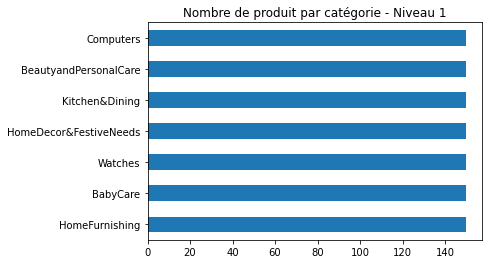

In [12]:
plt.title('Nombre de produit par catégorie - Niveau 1')
data_text['category_lvl1'].value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:title={'center':'Nombre de produit par catégorie - Niveau 2'}>

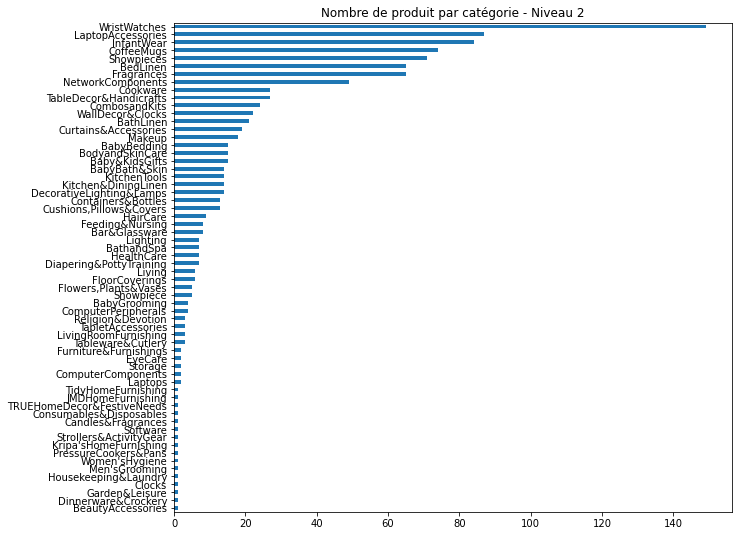

In [17]:
plt.figure(figsize = (10,9))
plt.title('Nombre de produit par catégorie - Niveau 2')
data_text['category_lvl2'].value_counts().sort_values().plot(kind = 'barh')

In [13]:
data_text['category_lvl1'].nunique()

7

### Category labels

In [14]:
data_text['category_lvl1'].unique()

array(['HomeFurnishing', 'BabyCare', 'Watches', 'HomeDecor&FestiveNeeds',
       'Kitchen&Dining', 'BeautyandPersonalCare', 'Computers'],
      dtype=object)

In [15]:
data_text['description'][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

# Text Cleaning

In [16]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [17]:
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('+', ' ').replace('/', ' ').replace('&', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']
def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw) 
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens) 
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [18]:
#nltk.download('punkt')

In [19]:
#nltk.download('wordnet')

In [20]:
#nltk.download('omw-1.4')

In [21]:
data_text['sentence_bow'] = data_text['description'].apply(lambda x : transform_bow_fct(x))
data_text['sentence_bow_lem'] = data_text['description'].apply(lambda x : transform_bow_lem_fct(x))
data_text['sentence_dl'] = data_text['description'].apply(lambda x : transform_dl_fct(x))
data_text.shape

(1050, 20)

In [22]:
#data_text.to_csv("data_text_final.csv")

In [2]:
data_text =  pd.read_csv("data_text_final.csv")
#data_text =  pd.read_csv("data_text.csv")

Before treatment

In [21]:
data_text['description'][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

After treatment

In [19]:
data_text['sentence_bow'][0]

'key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interiors.this curtain made 100 high quality polyester fabric.it features eyelet style stitch metal ring.it makes room environment romantic loving.this curtain ant- wrinkle anti shrinkage elegant apparance.give home bright modernistic appeal designs the surreal attention sure steal hearts these contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight. specifications elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed for door type eyelet model name abstract polyester door curtain set model duster25

In [3]:
data_text['sentence_bow']

0       key features elegance polyester multicolor abs...
1       specifications sathiyas cotton bath towel bath...
2       key features eurospa cotton terry face towel s...
3       key features santosh royal fashion cotton prin...
4       key features jaipur print cotton floral king s...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker pack pr...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker rs...
1049    buy uberlyfe large vinyl sticker rs.595 online...
Name: sentence_bow, Length: 1050, dtype: object

In [3]:
labelencoder = LabelEncoder()

In [4]:
y_cat_num = labelencoder.fit_transform(data_text['category_lvl1'])

In [5]:
l_cat = data_text['category_lvl1'].unique().tolist()
#y_cat_num =[(1-l_cat.index(data_text.iloc[0]['category_lvl1'])) for i in range(len(data_text))]

In [7]:
len(l_cat)

7

# Bag of word - Tf-idf

In [6]:
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

## Without ACP

In [7]:
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_text[feat])
ctf_fit = ctf.fit(data_text[feat])

cv_transform = cvect.transform(data_text[feat])  
ctf_transform = ctf.transform(data_text[feat])

In [8]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.3648 time :  15.0

Tf-idf : 
--------
ARI :  0.4093 time :  12.0


## With ACP

In [10]:
# Compute of principal component
pca_cv = decomposition.PCA(n_components=len(data_text[feat]),random_state=42)
X_pca_cv = pca_cv.fit_transform(cv_transform.toarray())

pca_ctf = decomposition.PCA(n_components=len(data_text[feat]),random_state=42)
X_pca_ctf = pca_ctf.fit_transform(ctf_transform.toarray())


In [11]:
# Number of features before PCA
print('Features before PCA: {}'.format(ctf_transform.shape[1]))

Features before PCA: 5386


In [12]:
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(X_pca_cv)
print()
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(X_pca_ctf)

CountVectorizer : 
-----------------
ARI :  0.3885 time :  13.0

Tf-idf : 
--------
ARI :  0.4323 time :  12.0


## CountVectorizer

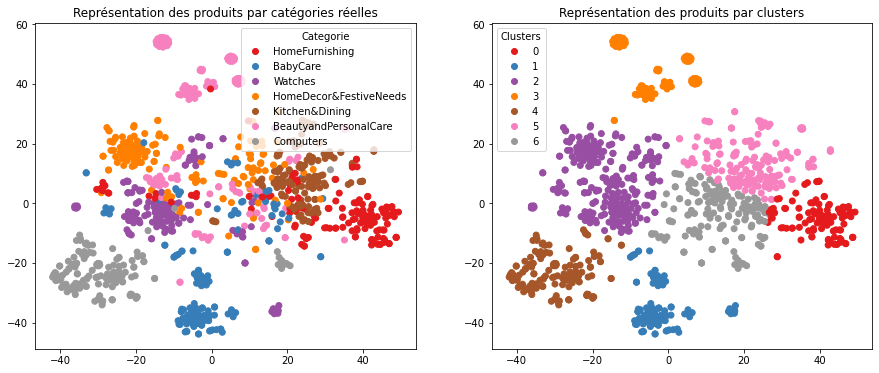

ARI :  0.3885


In [13]:
 TSNE_visu_fct(X_tsne_cv, y_cat_num, labels_cv, ARI_cv)

## Tf-idf

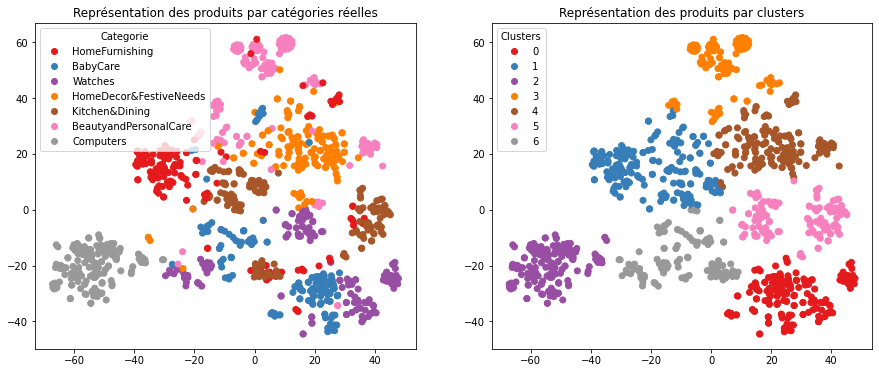

ARI :  0.4323


In [14]:
 TSNE_visu_fct(X_tsne_ctf, y_cat_num, labels_ctf, ARI_ctf)

# Word2Vec

## Creation of the Word2Vec model

In [16]:
# Bonus : Corpus2Vec

In [9]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100 #number of itteration over corpus
maxlen = 24 # adapt to length of sentences
sentences = data_text['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences] #Tokenize sentences

In [10]:
# Creation and training of the Word2Vec model

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences) # prepare the model vocabulary
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs) #train word vectors, total_example=count of sentences
model_vectors = w2v_model.wv # get numpy vector
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4712
Word2Vec trained


In [11]:
# Preparation of sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences) #vocabulary index based on word frequency
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), #ensure sequences of list have the same length
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1 #reserving padding (i.e. index zero)
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


## Creation of the embedding matrix

In [12]:
# Creation of the embedding matrix

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 #first token ID is 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4713, 300)


## Creation of the embedding model

In [13]:
# Creation of the model

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 300)           1413900   
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
Total params: 1,413,900
Trainable params: 1,413,900
Non-trainable params: 0
_________________________________________________________________


## Model execution

In [14]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(1050, 300)

In [25]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2163 time :  17.0


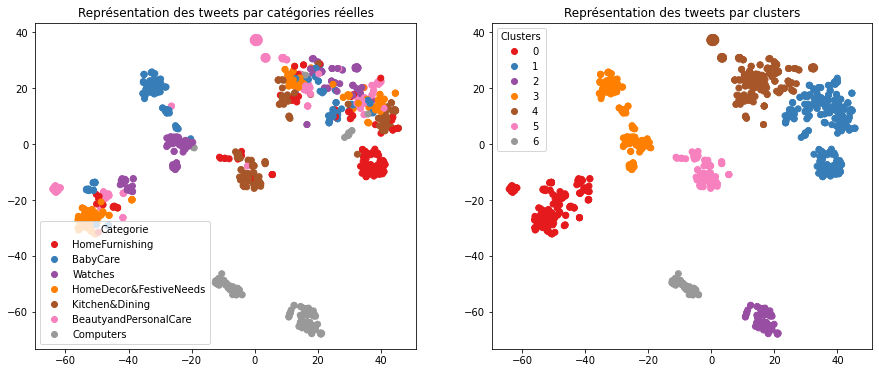

ARI :  0.2163


In [26]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [40]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.8.0
2.8.0
Num GPUs Available:  0
False


## Common functions

In [41]:
# Preparation function of sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Feature creation function
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [42]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_text['sentence_dl'].to_list()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/nax/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncas

In [43]:
# Feature creation

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/nax/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resol

temps traitement :  174.0


In [46]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.328 time :  10.0


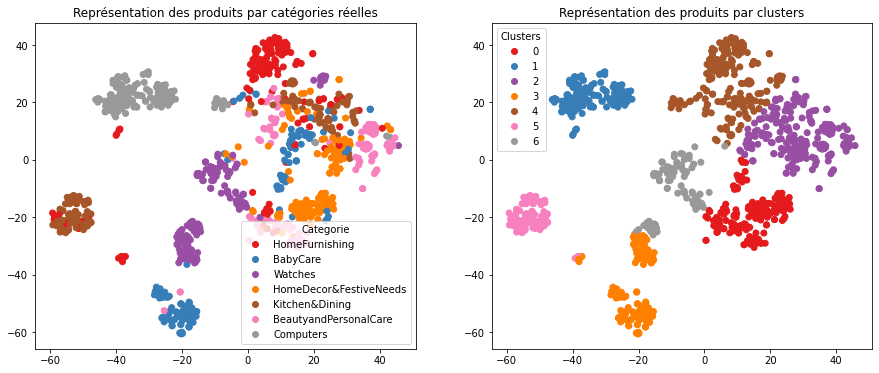

ARI :  0.328


In [47]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [17]:
#import tensorflow_hub as hub
#import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
#model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
#bert_layer = hub.KerasLayer(model_url, trainable=True)

INFO:absl:Using /var/folders/x4/5yq5_q792r58vht_w3fmzyvh0000gn/T/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4: 349.52MB
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4, Total size: 429.66MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.


# USE - Universal Sentence Encoder

# Bag of words

### Simple word count

In [49]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))  ### TF-IDF
print(tf.test.is_built_with_cuda())

2.8.0
2.8.0
Num GPUs Available:  0
False


In [50]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [51]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [52]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [53]:
batch_size = 10
sentences = data_text['sentence_dl'].to_list()

In [54]:
features_USE = feature_USE_fct(sentences, batch_size)

In [55]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4366 time :  10.0


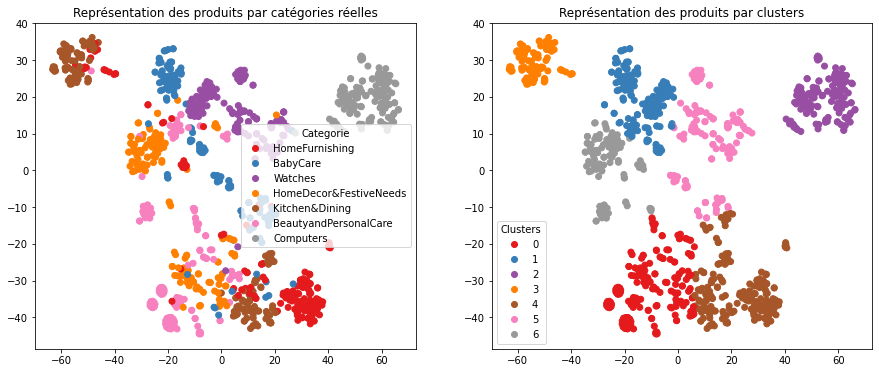

ARI :  0.4366


In [56]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)